# Gerekli Olan kütüphaneleri kuralım

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
import torch; 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


# Veri seti yolunu belirle

In [4]:
# Veri seti yolunu belirle  OriginalDataset, küçük, AugmentedAlzheimerDataset
data_dir = '/kaggle/input/OriginalDataset'

# Görüntüleri yüklemek için ImageDataGenerator kullanımı
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Eğitim ve doğrulama veri setlerini oluştur
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)
# Eğitim verilerini numpy array'e dönüştür
X_train, y_train = [], []
for i in range(len(train_generator)):
    x_batch, y_batch = train_generator[i]
    X_train.append(x_batch)
    y_train.append(y_batch)
    if i >= len(train_generator) - 1:
        break
X_train = np.concatenate(X_train)
y_train = np.argmax(np.concatenate(y_train), axis=1)

# Doğrulama verilerini numpy array'e dönüştür
X_val, y_val = [], []
for i in range(len(validation_generator)):
    x_batch, y_batch = validation_generator[i]
    X_val.append(x_batch)
    y_val.append(y_batch)
    if i >= len(validation_generator) - 1:
        break
X_val = np.concatenate(X_val)
y_val = np.argmax(np.concatenate(y_val), axis=1)

# Verileri düzleştir
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

# Verileri ölçeklendir
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


# SVM 

In [5]:
# SVM Modeli destek vektör
svm_model = SVC(kernel='linear', random_state=0) 
svm_model.fit(X_train_scaled, y_train)
# SVM ile tahmin
y_pred_svm = svm_model.predict(X_val_scaled)
svm_accuracy = accuracy_score(y_val, y_pred_svm)
print("SVM doğruluğu:", svm_accuracy)
print("SVM sınıflandırma raporu:\n", classification_report(y_val, y_pred_svm))



SVM doğruluğu: 0.6434714620797498
SVM sınıflandırma raporu:
               precision    recall  f1-score   support

           0       0.66      0.27      0.38       179
           1       1.00      0.33      0.50        12
           2       0.67      0.85      0.75       640
           3       0.59      0.51      0.54       448

    accuracy                           0.64      1279
   macro avg       0.73      0.49      0.54      1279
weighted avg       0.64      0.64      0.62      1279



In [19]:
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']
cm =confusion_matrix(y_val, y_pred_svm)
print(cm)

[[ 48   0  63  68]
 [  4   4   0   4]
 [  7   0 544  89]
 [ 14   0 207 227]]


# Random Forest

In [7]:
    # Random Forest Modeli
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    # Random Forest ile tahmin
    y_pred_rf = rf_model.predict(X_val_scaled)
    rf_accuracy = accuracy_score(y_val, y_pred_rf)
    print("Random Forest doğruluğu:", rf_accuracy)
    print("Random Forest sınıflandırma raporu :\n", classification_report(y_val, y_pred_rf))

Random Forest doğruluğu: 0.6333072713057076
Random Forest sınıflandırma raporu :
               precision    recall  f1-score   support

           0       1.00      0.09      0.16       179
           1       1.00      0.08      0.15        12
           2       0.72      0.76      0.74       640
           3       0.53      0.69      0.60       448

    accuracy                           0.63      1279
   macro avg       0.81      0.40      0.41      1279
weighted avg       0.69      0.63      0.60      1279



In [18]:
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']
cm = confusion_matrix(y_val, y_pred_rf)
print(cm)

[[ 16   0  49 114]
 [  0   1   3   8]
 [  0   0 486 154]
 [  0   0 141 307]]


# PCA nedir

Temel bileşen analizi (PCA), büyük veri kümelerindeki boyut sayısını, orijinal bilgilerin çoğunu koruyan temel bileşenlere indirger. Bunu, potansiyel olarak ilişkili değişkenleri temel bileşenler adı verilen daha küçük bir değişken kümesine dönüştürerek yapar.

# PCA ile Random Forest

In [9]:
    # PCA ile boyut indirgeme
    pca = PCA(n_components=0.95)  # %95 varyansı koruyacak şekilde
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)

    # PCA sonrası boyut bilgisi
    print(f"PCA sonrası eğitim verisi boyutu: {X_train_pca.shape}")
    print(f"PCA sonrası doğrulama verisi boyutu: {X_val_pca.shape}")

    # Random Forest Modeli
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_pca, y_train)

    # PCA sonrası model doğruluk testi
    y_pred_rfpca = rf_model.predict(X_val_pca)
    rf_accuracy = accuracy_score(y_val, y_pred_rfpca)
    print("PCA sonrası Random Forest doğruluk:", rf_accuracy)
    print("PCA sonrası Random Forest sınıflandırma raporu:\n", classification_report(y_val, y_pred_rf))

PCA sonrası eğitim verisi boyutu: (5121, 1316)
PCA sonrası doğrulama verisi boyutu: (1279, 1316)
PCA sonrası Random Forest doğruluk: 0.5527756059421423
PCA sonrası Random Forest sınıflandırma raporu:
               precision    recall  f1-score   support

           0       1.00      0.09      0.16       179
           1       1.00      0.08      0.15        12
           2       0.72      0.76      0.74       640
           3       0.53      0.69      0.60       448

    accuracy                           0.63      1279
   macro avg       0.81      0.40      0.41      1279
weighted avg       0.69      0.63      0.60      1279



In [17]:
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']
cm = confusion_matrix(y_val, y_pred_rfpca)
print(cm)

[[  1   0 150  28]
 [  0   0   8   4]
 [  0   0 592  48]
 [  0   0 334 114]]


# PCA ile birlikte *SVM*

In [11]:
    # PCA ile boyut indirgeme
    pca = PCA(n_components=0.95)  # %95 varyansı koruyacak şekilde
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)

    # PCA sonrası boyut bilgisi
    print(f"PCA sonrası eğitim verisi boyutu: {X_train_pca.shape}")
    print(f"PCA sonrası doğrulama verisi boyutu: {X_val_pca.shape}")


    # SVM Modeli
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_train_pca, y_train)

    # PCA sonrası SVM doğruluk testi
    y_pred_svmpca = svm_model.predict(X_val_pca)
    svm_accuracy = accuracy_score(y_val, y_pred_svmpca)
    print("PCA sonrası SVM doğruluk:", svm_accuracy)
    print("PCA sonrası SVM sınıflandırma raporu:\n", classification_report(y_val, y_pred_svm)),

PCA sonrası eğitim verisi boyutu: (5121, 1316)
PCA sonrası doğrulama verisi boyutu: (1279, 1316)
PCA sonrası SVM doğruluk: 0.6278342455043002
PCA sonrası SVM sınıflandırma raporu:
               precision    recall  f1-score   support

           0       0.66      0.27      0.38       179
           1       1.00      0.33      0.50        12
           2       0.67      0.85      0.75       640
           3       0.59      0.51      0.54       448

    accuracy                           0.64      1279
   macro avg       0.73      0.49      0.54      1279
weighted avg       0.64      0.64      0.62      1279



(None,)

In [16]:
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']
cm = confusion_matrix(y_val, y_pred_svmpca)
print(cm)

[[ 47   0  69  63]
 [  4   4   0   4]
 [  9   0 531 100]
 [ 21   0 206 221]]


# lojistik regresyon

In [3]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

# veri setini alma işlemleri

In [4]:
import os
data_dir = '/kaggle/input/OriginalDataset'
DataSet = os.listdir(data_dir)
categories = {
    'MildDemented': 0,
    'ModerateDemented': 1,
    'NonDemented': 2,
    'VeryMildDemented': 3
}

# şeklini belli bir size içine almamız gerekmekte

In [5]:
import cv2 as cv
images =[]
category = []
for cls in categories:
    path = "/kaggle/input/OriginalDataset/" + cls
    for j in os.listdir(path):
        imgArr = cv.imread(path+'/'+j, 0)
        imgArr = cv.resize(imgArr, (256, 256))
        # imgResize = imgArr
        images.append(imgArr)
        category.append(categories[cls])

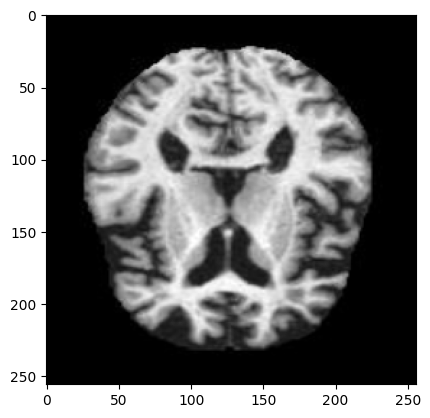

(6400, 65536)

In [6]:
np.unique(category)
imgs = np.array(images)
categ = np.array(category)
pd.Series(categ).value_counts()
imgs.shape
imgs.shape[1]

plt.imshow(imgs[2], cmap='gray')
plt.show()

imgsUpdated =  imgs.reshape(len(imgs), -1)
imgsUpdated.shape

In [7]:
xtrain, xtest, ytrain, ytest = train_test_split(imgsUpdated, categ, random_state= 42, test_size = 0.2)
xtrain.shape, xtest.shape

((5120, 65536), (1280, 65536))

In [8]:
print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())
xtrain = xtrain / 255
xtest = xtest / 255
print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())

255 0
255 0
1.0 0.0
1.0 0.0


# shape işlemleri bittikten sonra burda gidip pca kullanılabilir veya direkt olarak lojistik regresyon ile makine öğrenmesine tabi tutulur

In [10]:
from sklearn.decomposition import PCA
pca = PCA(.98)
pca_train = pca.fit_transform(xtrain)
pca_test = pca.transform(xtest)
pca_train = xtrain
pca_test = xtest

from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(C=0.1)
lg.fit(pca_train, ytrain)
#ortalama 25dk

LogisticRegression(C=0.1)

In [1]:
import joblib
#joblib.dump(lg, 'logistic.joblib')
logistic = joblib.load('/kaggle/input/logistic/other/default/1/logistic.joblib')

#bi de göstermek için test verisetini indirelim
#joblib.dump(pca_test,'test.joblib')
pca_test = joblib.load('/kaggle/input/pca-testalzheimershaped/test.joblib')

# elde edilen test ve eğitim verileri için başarı skorları

In [13]:
print("eğitim skoru: ", lg.score(pca_train, ytrain) * 100)
print("test skoru: ", lg.score(pca_test, ytest) * 100)

eğitim skoru:  96.09375
test skoru:  89.765625


In [13]:
#eğer veri seti dışında bir görsel tahmin ettirilmeye 
#çalışılırsa görsel de aynı şekilde PCA işlemine maruz kalmalıdr
#pca_img = pca.fit(img)
#predict = lg.predict(pca_img)
predict = logistic.predict(pca_test)
print("tahmin edilen sınıf:",predict[27]) 

#ekstra olarak nadir sınıfları bulmak için
for i in range(1,1279):
    if(predict[i] == 1):
        print(i,". eleman 1. sınıfa aittir")


#999,14 için 0. sınıfa   
#28,53 gibiler de 1. sınıfa aittir
# genel olarak 2 ve 3 tahminleri yapıyor 1 oldukça azınlıkta
#MildDemented:0 ModerateDemented:1 NonDemented:2 VeryMildDemented:

tahmin edilen sınıf: 2
28 . eleman 1. sınıfa aittir
53 . eleman 1. sınıfa aittir
58 . eleman 1. sınıfa aittir
387 . eleman 1. sınıfa aittir
1236 . eleman 1. sınıfa aittir
1269 . eleman 1. sınıfa aittir


# sonuç 

**Çeşitli denemeler sonunda original dataset verisi ile en uygun olan sınıflandırma biçimi Lojistik Regresyondur.en kötü sonuçları random forest vermiştir, SVM daha iyi bire performans verse de tercih edilmemesi gereken bir modeldir.Bu veri seti için original dataset aslında oldukça dengesiz bir veri seti olmakla beraber augmented hali ise işlemesi onlarca saati alabilen görüntüleri içermektedir bu PCA (temel bileşen analizi) gibi yöntemlerle bu süreci hızlandırmaya çalışmış bulunmaktayım. Ek bir bilgi olarak bu verisetinde bulunan görseller sabit bir noktadan alınmamıştır yani beynin bazen biraz daha üst kısımlarındaki görüntüler varken bazı görüntüler burun hizasındadır bu da verisetinin güvenilirliğini oldukça düşürüyor.**
